## Image Segmentation


#### 데이터 로드 및 전처리

1. **JSON 파일 로드**:
   - 주어진 디렉토리에서 JSON 파일을 모두 로드하여 리스트로 저장

2. **create_mask_from_polygon()**:
   - 이미지에 폴리곤 좌표를 이용해 마스크를 생성

3. **preprocess_data()**:
   - 이미지를 로드하고, 폴리곤 데이터를 기반으로 마스크를 생성하여 전처리된 이미지와 마스크 배열을 반환

#### U-Net 모델 정의

1. **U-Net 모델 생성**:
   - 인코더와 디코더 블록을 포함하는 U-Net 모델을 정의하여 이미지 분할 작업에 사용
   - 인코더는 이미지를 다운샘플링하고, 디코더는 업샘플링하여 원본 이미지 크기로 복원
   - 스킵 연결을 사용하여 인코더의 특징 맵을 디코더에 전달

### 요약

- JSON 파일을 로드하고, 이미지와 폴리곤 데이터를 사용하여 마스크를 생성 및 전처리
- U-Net 모델을 정의하여 이미지 분할 작업을 수행 인코더와 디코더 블록, 스킵 연결을 사용하여 높은 정확도를 제공


In [ ]:
import os
import json
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# 데이터 로드 및 전처리 함수
def load_json_files(json_dir):
    json_files = [os.path.join(json_dir, f) for f in os.listdir(json_dir) if f.endswith('.json')]
    data = []
    for json_file in json_files:
        with open(json_file, 'r', encoding='utf-8') as file:
            data.append(json.load(file))
    return data

def create_mask_from_polygon(polygon, shape):
    mask = np.zeros(shape, dtype=np.uint8)
    points = np.array(polygon, dtype=np.int32)
    cv2.fillPoly(mask, [points], 1)
    return mask

def preprocess_data(data, img_dir, target_size=(256, 256)):
    images = []
    masks = []
    for item in data:
        img_info = item['이미지 정보']
        img_name = '%d.jpg' % img_info['이미지 식별자']
        img_path = os.path.join(img_dir, img_name)

        if not os.path.exists(img_path):
            print(f"Image path does not exist: {img_path}")
            continue

        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        img_height, img_width = img.shape[:2]

        mask = np.zeros((img_height, img_width), dtype=np.uint8)

        # 상의 폴리곤 좌표
        for polygon in item['데이터셋 정보']['데이터셋 상세설명']['폴리곤좌표']['상의']:
            if polygon:
                coords = [(polygon[f'X좌표{i}'], polygon[f'Y좌표{i}']) for i in range(1, len(polygon) // 2 + 1)]
                mask += create_mask_from_polygon(coords, (img_height, img_width))

        # 하의 폴리곤 좌표
        for polygon in item['데이터셋 정보']['데이터셋 상세설명']['폴리곤좌표']['하의']:
            if polygon:
                coords = [(polygon[f'X좌표{i}'], polygon[f'Y좌표{i}']) for i in range(1, len(polygon) // 2 + 1)]
                mask += create_mask_from_polygon(coords, (img_height, img_width)) * 2

        mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        mask[mask > 2] = 2
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# UNet 모델 정의
def unet_model(input_size=(256, 256, 3), num_classes=3):
    inputs = layers.Input(input_size)

    # 인코더
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # 중심
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # 디코더
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# 설정 및 모델 인스턴스 생성
input_size = (256, 256, 3)
num_classes = 3  # 배경 + 상의 + 하의


In [ ]:
json_dir = './data/topbottom_label'
img_dir = './data/resized_images'
data = load_json_files(json_dir)
images, masks = preprocess_data(data, img_dir)
# 모델 학습

In [ ]:
model = unet_model(input_size=input_size, num_classes=num_classes)

# 모델 컴파일
model.compile(optimizer=optimizers.Adam(learning_rate=3e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 256, 256, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_28[0][0]']              
                                )                                                           

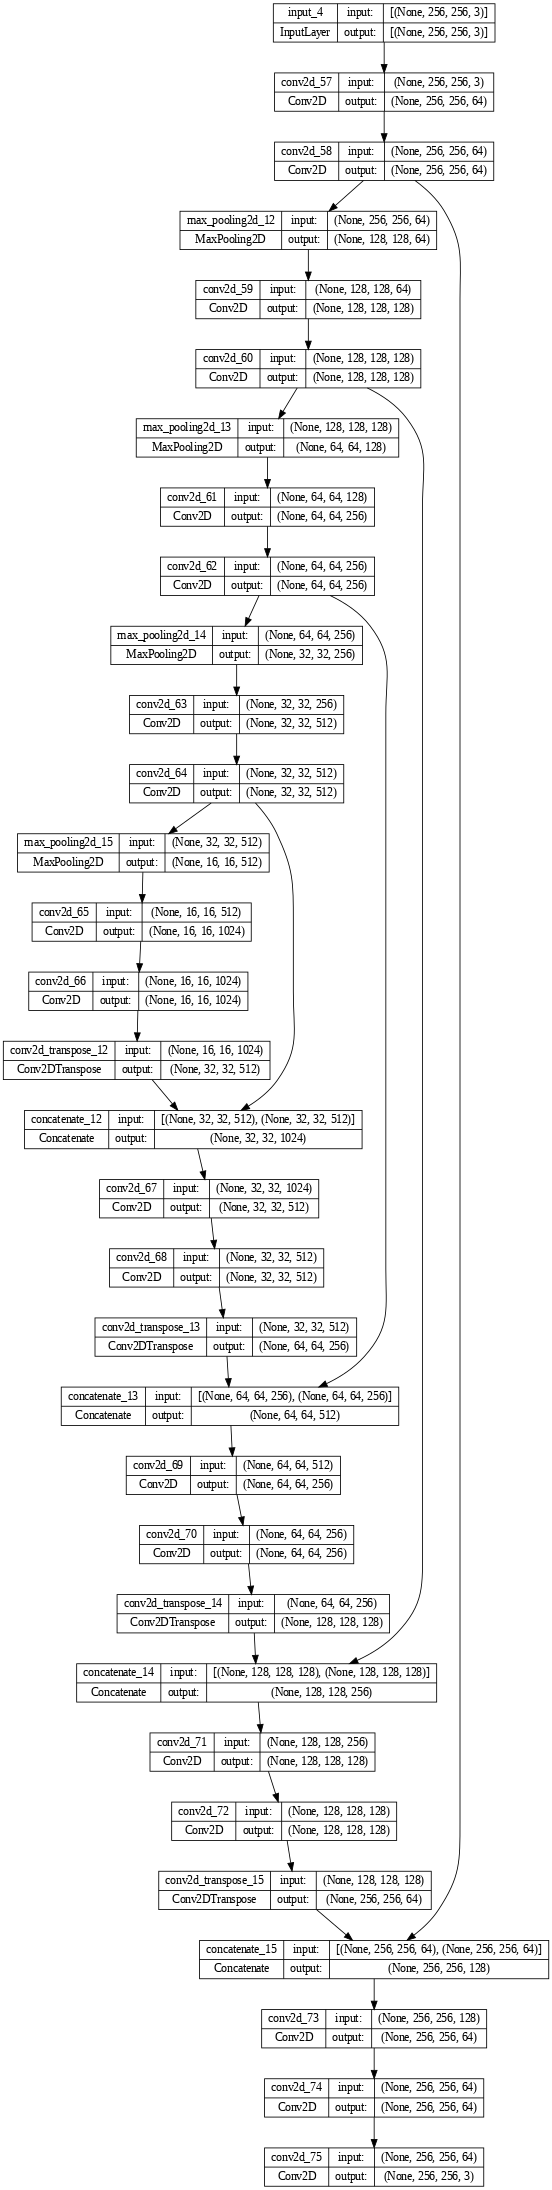

In [ ]:
from tensorflow.keras.utils import plot_model
# 모델 구조 시각화
plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True, dpi=60)


### Train

### 코드 설명
   - `batch_size=32`: 배치 크기는 32로 설정
   - `epochs=40`: 총 40 에포크 동안 훈련
   - `loss` : sparse_categorical_crossentropy
   - `learning rate` = 3e-4
   - `metrics` = accuracy
   - `classes` = 3 (상의, 하의, 배경)





In [ ]:
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_images, train_masks, batch_size=32)
val_generator = val_datagen.flow(val_images, val_masks, batch_size=32)

checkpoint = ModelCheckpoint(
    filepath='model_epoch_{epoch:02d}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_freq='epoch'
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    steps_per_epoch=len(train_images) // 32,
    validation_steps=len(val_images) // 32,
    callbacks=[checkpoint]
)

model.save('final_model.h5')


Epoch 1/40
377/377 [==============================] - ETA: 0s - loss: 0.4159 - accuracy: 0.8291
Epoch 1: saving model to model_epoch_01.h5
377/377 [==============================] - 564s 1s/step - loss: 0.4159 - accuracy: 0.8291 - val_loss: 0.3575 - val_accuracy: 0.8537
Epoch 2/40
377/377 [==============================] - ETA: 0s - loss: 0.3075 - accuracy: 0.8772
Epoch 2: saving model to model_epoch_02.h5
377/377 [==============================] - 565s 1s/step - loss: 0.3075 - accuracy: 0.8772 - val_loss: 0.2889 - val_accuracy: 0.8879
Epoch 3/40
377/377 [==============================] - ETA: 0s - loss: 0.2598 - accuracy: 0.8972
Epoch 3: saving model to model_epoch_03.h5
377/377 [==============================] - 565s 1s/step - loss: 0.2598 - accuracy: 0.8972 - val_loss: 0.2617 - val_accuracy: 0.9000
Epoch 4/40
377/377 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 0.9105
Epoch 4: saving model to model_epoch_04.h5
377/377 [==============================] - 564s 

KeyboardInterrupt: 

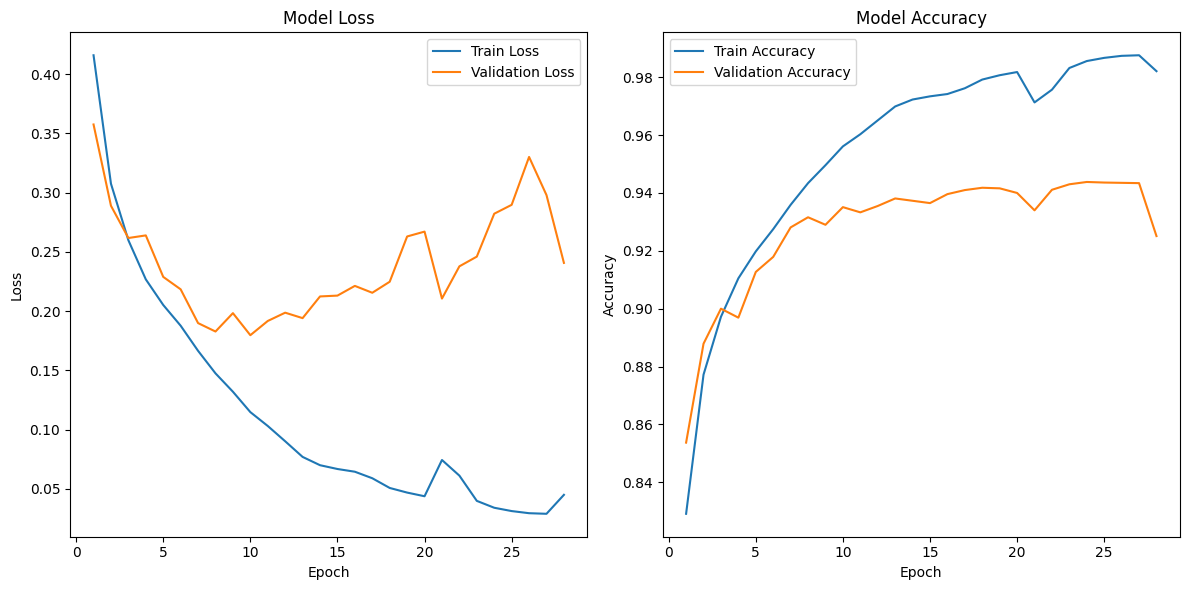

### Develop
 주요 차이점

1. **컨볼루션 필터 수**:
    - `unet_model`: 각 레벨에서 64개의 필터로 시작하여 128, 256, 512, 1024로 증가
    - `unet_model2`: 각 레벨에서 32개의 필터로 시작하여 64, 128, 256, 512로 증가 필터 수가 절반으로 시작하여 모델의 복잡도가 상대적으로 낮음.

2. **Batch Normalization**:
    - `unet_model`: Batch Normalization을 사용하지 않음.
    - `unet_model2`: 각 컨볼루션 레이어 뒤에 Batch Normalization을 추가하여 학습을 안정화하고 성능을 향상시킴.

3. **Dropout 레이어**:
    - `unet_model`: Dropout 레이어를 사용하지 않음.
    - `unet_model2`: 각 MaxPooling 레이어 뒤에 Dropout(0.5)을 추가하여 모델이 과적합되는 것을 방지

4. **디코더 필터 수**:
    - `unet_model`: 디코더 단계에서 필터 수가 512, 256, 128, 64로 줄어듬
    - `unet_model2`: 디코더 단계에서 필터 수가 256, 128, 64, 32로 줄어듬

일반화 성능을 높이기 위해
- `unet_model2`는 더 낮은 파라미터 수와 과적합 방지를 위한 추가 기법(Batch Normalization과 Dropout)을 포함
-   `unet_model`은 더 높은 필터 수와 단순한 구조를 가지고 있어 더 많은 특징을 추출할 수 있지만, 과적합될 가능성이 더 높음.

In [ ]:
def unet_model2(input_size=(256, 256, 3), num_classes=3):
    inputs = layers.Input(input_size)

    # 인코더
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.5)(p1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.5)(p2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(0.5)(p3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    p4 = layers.Dropout(0.5)(p4)

    # 중심
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)

    # 디코더
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

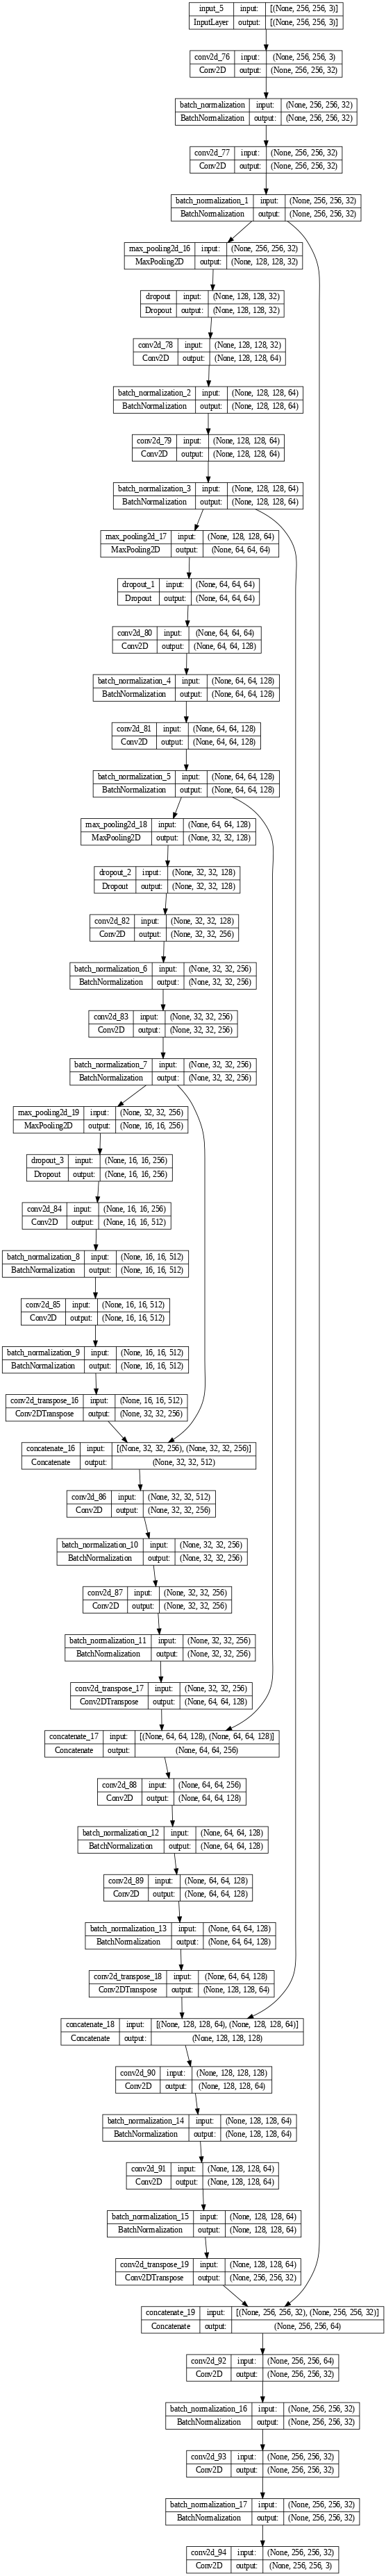

In [ ]:
model2 = unet_model2(input_size, num_classes)

# 모델 구조 시각화
plot_model(model2, to_file='unet_model.png', show_shapes=True, show_layer_names=True, dpi=60)


In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', iou_metric])

# 체크포인트 설정
checkpoint = ModelCheckpoint(
    filepath='model_epoch_{epoch:02d}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_freq='epoch'
)

# 모델 학습
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    steps_per_epoch=train_size // batch_size,
    validation_steps=val_size // batch_size,
    callbacks=[checkpoint]
)

# 최종 모델 저장
model.save('final_model.h5')


Epoch 1/40
377/377 [==============================] - ETA: 0s - loss: 0.7774 - accuracy: 0.7669 - iou_metric: 1.3471
Epoch 1: saving model to model_epoch_01.h5
377/377 [==============================] - 296s 708ms/step - loss: 0.7774 - accuracy: 0.7669 - iou_metric: 1.3471 - val_loss: 0.7863 - val_accuracy: 0.7813 - val_iou_metric: 0.8139
Epoch 2/40
377/377 [==============================] - ETA: 0s - loss: 0.5443 - accuracy: 0.8446 - iou_metric: 1.8502
Epoch 2: saving model to model_epoch_02.h5
377/377 [==============================] - 274s 713ms/step - loss: 0.5443 - accuracy: 0.8446 - iou_metric: 1.8502 - val_loss: 0.5683 - val_accuracy: 0.8161 - val_iou_metric: 0.9486
Epoch 3/40
377/377 [==============================] - ETA: 0s - loss: 0.4439 - accuracy: 0.8627 - iou_metric: 2.2362
Epoch 3: saving model to model_epoch_03.h5
377/377 [==============================] - 278s 722ms/step - loss: 0.4439 - accuracy: 0.8627 - iou_metric: 2.2362 - val_loss: 0.4820 - val_accuracy: 0.8552 - 

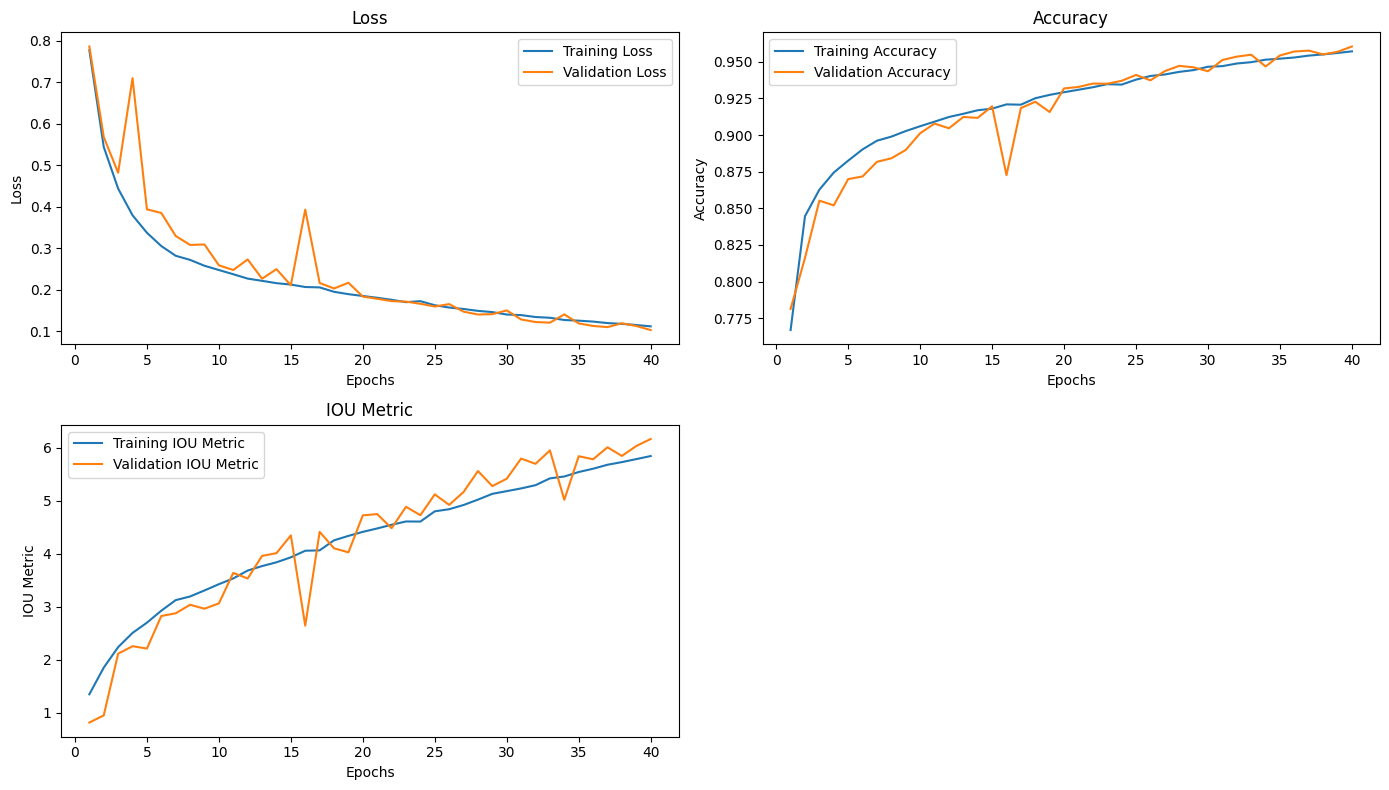

### 시각화
 -  정성적 평가 결과, 처음 학습 했던 UNET이 낫다고 판단, unet1의 epoch 10 모델 선정

1/1 [==============================] - 0s 185ms/step


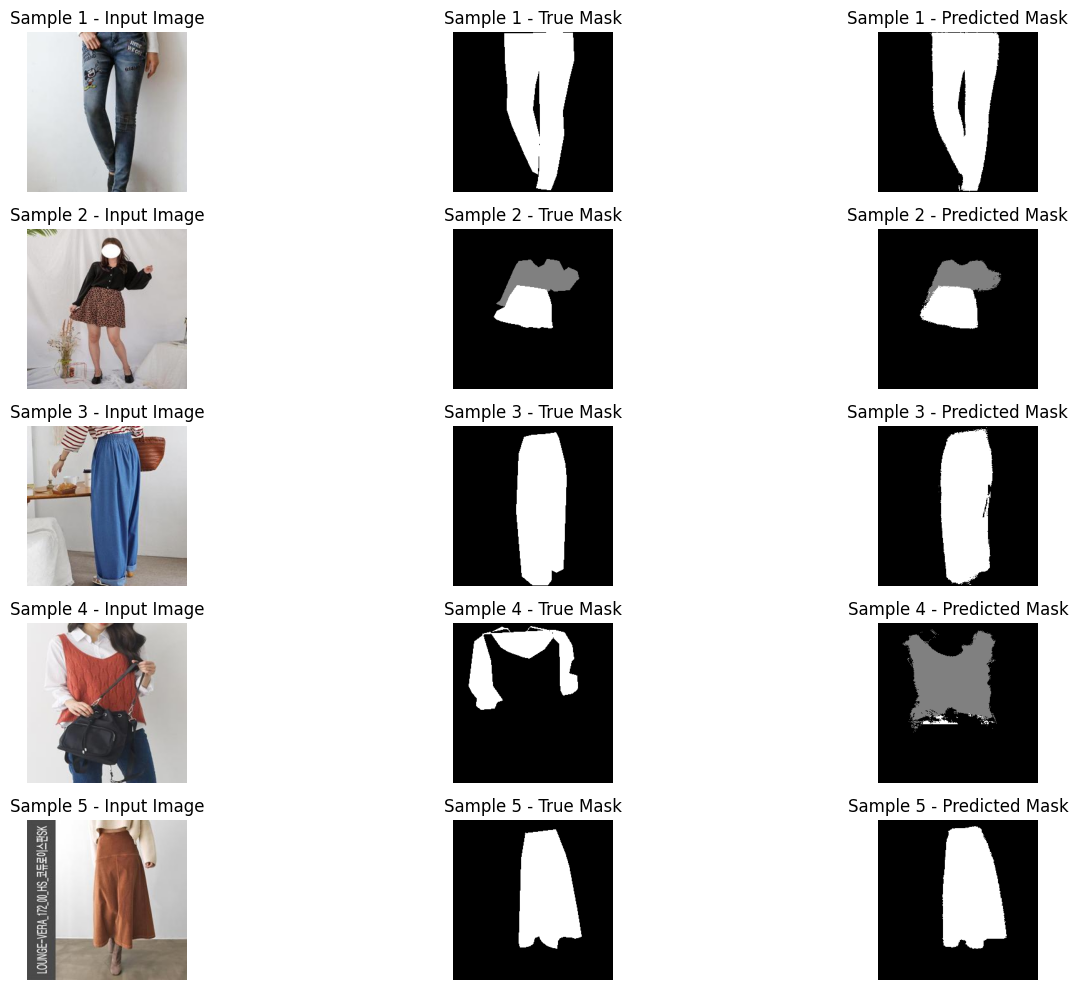

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the model from epoch 11
model = load_model('model_epoch_10.h5')

# Number of samples to visualize
num_samples = 5

# Select random samples from the validation set
indices = np.random.choice(len(val_images), num_samples, replace=False)
selected_images = val_images[indices]
selected_masks = val_masks[indices]

# Make predictions
predicted_masks = model.predict(selected_images)
predicted_masks = np.argmax(predicted_masks, axis=-1)

# Plotting the results
plt.figure(figsize=(15, 10))

for i in range(num_samples):
    image = selected_images[i]
    true_mask = selected_masks[i]
    pred_mask = predicted_masks[i]

    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.title(f"Sample {i+1} - Input Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.title(f"Sample {i+1} - True Mask")
    plt.imshow(true_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.title(f"Sample {i+1} - Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 192ms/step


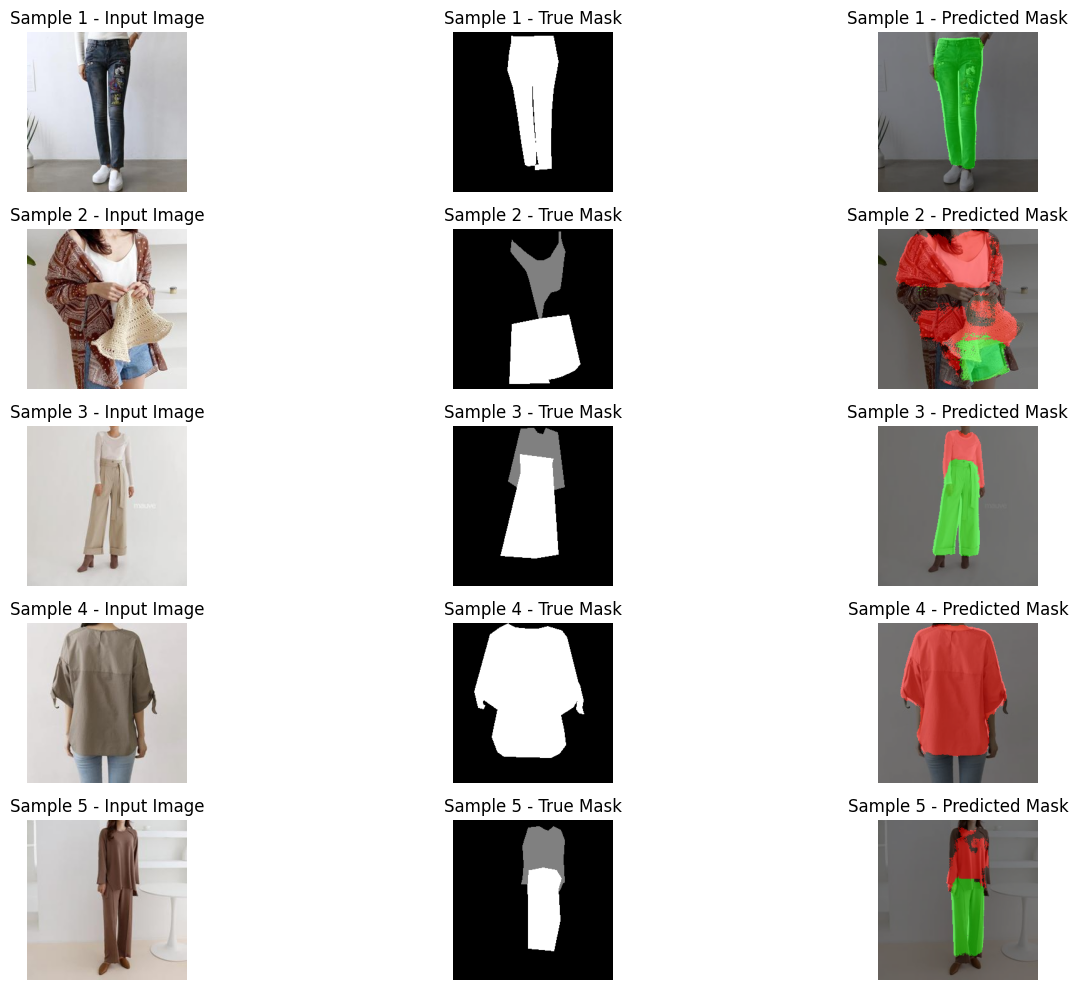

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2

# Load the model from epoch 11
model = load_model('model_epoch_10.h5')

# Number of samples to visualize
num_samples = 5

# Select random samples from the validation set
indices = np.random.choice(len(val_images), num_samples, replace=False)
selected_images = val_images[indices]
selected_masks = val_masks[indices]

# Make predictions
predicted_masks = model.predict(selected_images)
predicted_masks = np.argmax(predicted_masks, axis=-1)

def overlay_mask(image, mask, alpha=0.5):
    color_mask = np.zeros_like(image)
    color_mask[mask == 1] = [255, 0, 0]  # Color for class 1 (e.g., upper body)
    color_mask[mask == 2] = [0, 255, 0]  # Color for class 2 (e.g., lower body)

    overlayed_image = cv2.addWeighted(image, alpha, color_mask, 1 - alpha, 0)
    return overlayed_image

# Plotting the results
plt.figure(figsize=(15, 10))

for i in range(num_samples):
    image = selected_images[i]
    true_mask = selected_masks[i]
    pred_mask = predicted_masks[i]

    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.title(f"Sample {i+1} - Input Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.title(f"Sample {i+1} - True Mask")
    plt.imshow(true_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.title(f"Sample {i+1} - Predicted Mask")
    overlayed_image = overlay_mask(image, pred_mask)
    plt.imshow(overlayed_image)
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 174ms/step


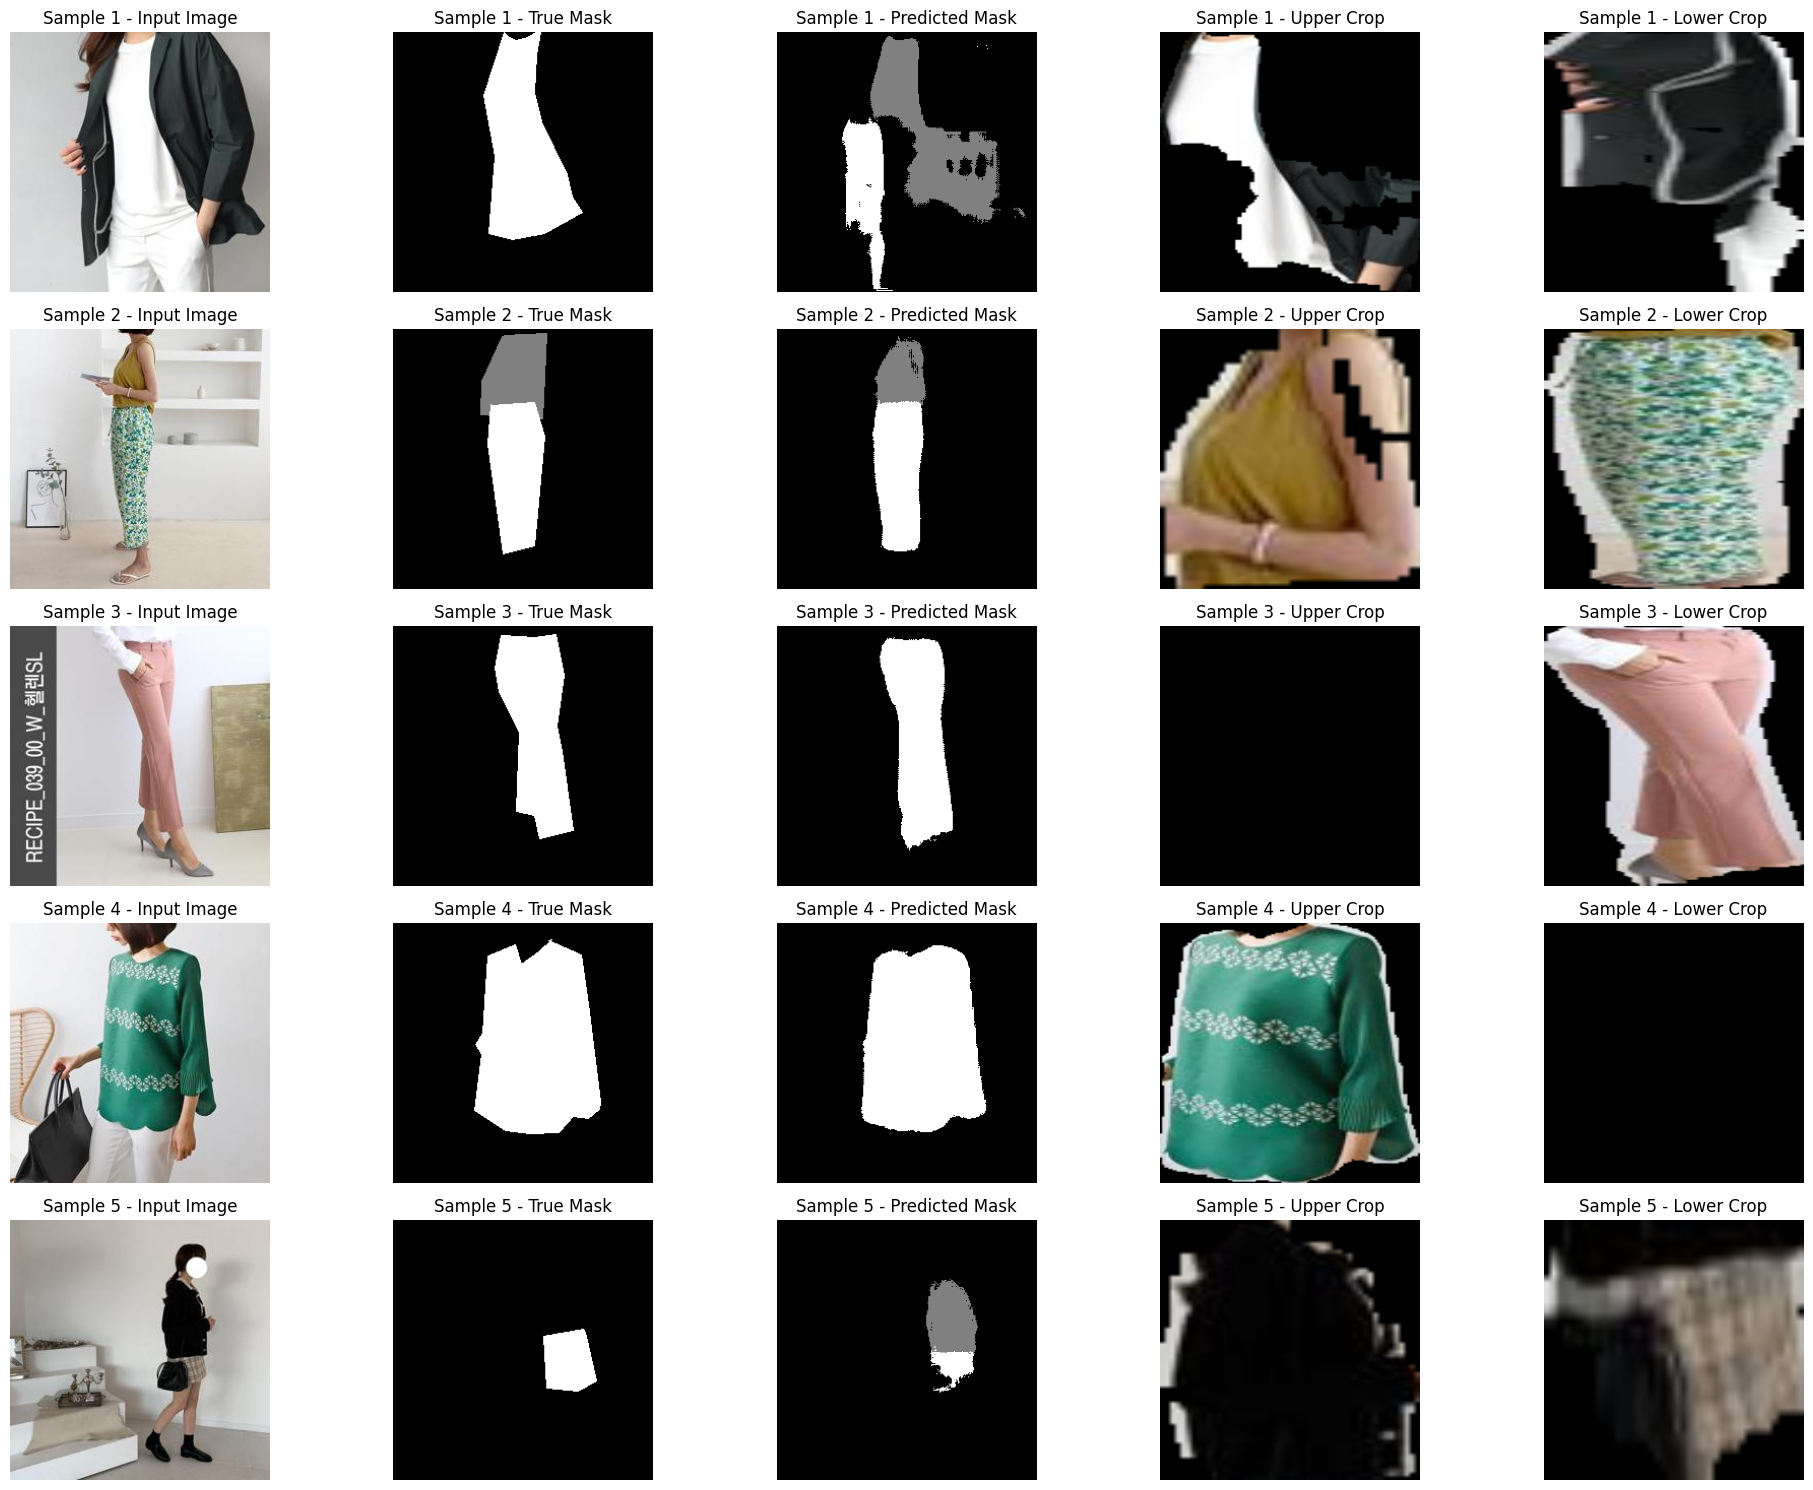

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def extract_and_crop(image, mask, class_id, target_size=(256, 256)):
    """
    이미지와 마스크에서 특정 클래스를 크롭하고, 크롭된 이미지를 타겟 크기로 리사이즈합니다.

    Parameters:
    image (np.array): 원본 이미지.
    mask (np.array): 예측된 마스크.
    class_id (int): 크롭할 클래스의 ID (예: 1은 상의, 2는 하의).
    target_size (tuple): 리사이즈할 타겟 크기 (기본값: (256, 256)).

    Returns:
    cropped_image (np.array): 크롭된 이미지.
    """
    # 해당 클래스의 마스크 추출
    class_mask = (mask == class_id).astype(np.uint8)

    # 노이즈 제거를 위한 모폴로지 연산 (열기 연산)
    kernel = np.ones((5, 5), np.uint8)
    class_mask = cv2.morphologyEx(class_mask, cv2.MORPH_OPEN, kernel)

    # 연결된 컴포넌트를 찾아 경계 상자 계산
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(class_mask, connectivity=8)

    # 가장 큰 연결 컴포넌트의 경계 상자 추출 (0번 레이블은 배경이므로 제외)
    if num_labels > 1:  # Ensure there are connected components detected
        largest_component = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        x, y, w, h = stats[largest_component, cv2.CC_STAT_LEFT], stats[largest_component, cv2.CC_STAT_TOP], stats[largest_component, cv2.CC_STAT_WIDTH], stats[largest_component, cv2.CC_STAT_HEIGHT]

        # 원본 이미지에서 해당 영역 크롭
        cropped_image = image[y:y+h, x:x+w]

        # 마스크된 원본 이미지 생성
        masked_image = cv2.bitwise_and(cropped_image, cropped_image, mask=class_mask[y:y+h, x:x+w])

        # 타겟 크기로 리사이즈
        resized_image = cv2.resize(masked_image, target_size, interpolation=cv2.INTER_LINEAR)

        return resized_image
    else:
        return np.zeros((*target_size, 3), dtype=np.uint8)  # Return an empty image if no components are found

# Load the model from epoch 11
model = load_model('model_epoch_11.h5')

# Number of samples to visualize
num_samples = 5

# Select random samples from the validation set
indices = np.random.choice(len(val_images), num_samples, replace=False)
selected_images = val_images[indices]
selected_masks = val_masks[indices]

# Make predictions
predicted_masks = model.predict(selected_images)
predicted_masks = np.argmax(predicted_masks, axis=-1)

# Plotting the results
plt.figure(figsize=(20, 15))

for i in range(num_samples):
    image = selected_images[i]
    true_mask = selected_masks[i]
    pred_mask = predicted_masks[i]

    # 상의 크롭
    upper_crop = extract_and_crop(image, pred_mask, class_id=1)
    # 하의 크롭
    lower_crop = extract_and_crop(image, pred_mask, class_id=2)

    plt.subplot(num_samples, 5, i * 5 + 1)
    plt.title(f"Sample {i+1} - Input Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(num_samples, 5, i * 5 + 2)
    plt.title(f"Sample {i+1} - True Mask")
    plt.imshow(true_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(num_samples, 5, i * 5 + 3)
    plt.title(f"Sample {i+1} - Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(num_samples, 5, i * 5 + 4)
    plt.title(f"Sample {i+1} - Upper Crop")
    plt.imshow(upper_crop)
    plt.axis('off')

    plt.subplot(num_samples, 5, i * 5 + 5)
    plt.title(f"Sample {i+1} - Lower Crop")
    plt.imshow(lower_crop)
    plt.axis('off')

plt.tight_layout()
plt.show()
